In [97]:
import numpy as np
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
import glob, os
%matplotlib notebook

In [98]:
# Parse the maximum current, p gain, d gain from the file name

def get_Imax_P_D_from_file(file):
    current = float(file[file.find("I")+1:file.find("p")])
    p_gain =  float(file[file.find("p")+1:file.find("d")])/1000
    d_gain =  float(file[file.find("d")+1:file.find(".")])/1000
    return (current,p_gain,d_gain)

# Return tuple of (positions, times) from given data file
def load_position_time_vectors(filename):
    data = np.load(filename)
    return (data[:,1],data[:,0])

# Get position vector from data collected from the V1 1.5s step test
def v1_get_step_subset(position_vector):
    step2_index = [500,600] 
    step2_data = position_vector[slice(*step2_index)]
    return step2_data

# Create a matrix of specifications from each step test
# In format: [current, p, d, Mp, tr, ts, damp]
def load_all_data(filename_format):
    filenames = glob.glob(filename_format)
    num_files = len(filenames)
    
    param_matrix = np.zeros((num_files,7))
    param_matrix.fill(np.nan)
                            
    index = 0
    for filename in filenames:
        # Get max current, p, d gains from filename
        (current, p_gain, d_gain) = get_Imax_P_D_from_file(filename)

        # Load encoder angle history and teensy timestamps
        (position,times) = load_position_time_vectors(filename)

        # Indicies specifying which phases happen when
        step2_data = v1_get_step_subset(position)

        dt = 0.002

        Mp = overshoot(step2_data)
        tr = rise_time(step2_data, dt)
        ts = settling_time(step2_data, dt)
        damp2 = damping_from_tstr(step2_data,dt)
        # Can also find damping coeff from the overshoot,
        # but doesn't apply for damp > 1
        # damp = damping_from_Mp(step2_data)
        
        param_matrix[index,:] = np.array([current, p_gain, d_gain, Mp, tr, ts, damp2])
        index += 1
        
    return param_matrix

In [99]:
## Analyze overshoot during first step ##
def overshoot(step_position):
    # maximum angle (overshoot over 180deg)
    end_val = step_position[-1]
    start_val = step_position[0]
    if end_val > start_val:
        max_val = np.max(step_position)
    else:
        max_val = np.min(step_position)
        
    # difference btn maximum and steady state value
    overshoot = abs(max_val - end_val)

    # magnitude in degrees of the step upwards
    step_size = abs(end_val - start_val)

    # maximum overshoot parameter
    return overshoot / step_size

## Analyze rise time
def rise_time(step_position, dt):
    # should robably find the dt from the time variable instead

    # 10% mark
    # signed size of the step
    initial_val = step_position[0]
    ss_val = step_position[-1]
    step_size = ss_val - initial_val
    
    ten_percent = initial_val + 0.1 * step_size
    ninety_percent = initial_val + 0.9 * step_size

    if ss_val > initial_val:
        rise_time = (np.argmax(step_position > ninety_percent) - 
              np.argmax(step_position > ten_percent)) * dt
    else:
        rise_time = (np.argmax(step_position < ninety_percent) - 
              np.argmax(step_position < ten_percent)) * dt

    return rise_time

## Find the settling time (oscillation < 1% of ss value)
def settling_time(step_position, dt):
    # take the last entry as the steady state value
    initial_val = step_position[0]
    ss_val = step_position[-1]
    step_size = abs(ss_val - initial_val)
    
    last_steady_index = 0
    
    logical_greater_than_ss = (abs(step_position - ss_val) > step_size * 0.01)
    
    # reverse the logical array to find the last index of TRUE, which indicates
    # the first datum within 1% of the ss value
    index_last_out_of_bounds = ((step_position.size - 1) - 
            np.argmax(logical_greater_than_ss[::-1]))
    
    return index_last_out_of_bounds * dt

## Estimates the damping coefficient from the amount of overshoot
def damping_from_Mp(step_position):
    Mp = overshoot(step_position)
    return damping_from_Mp_given_Mp(Mp)

def damping_from_Mp_given_Mp(Mp):
    if Mp < 0.001:
        return 1.0
    return (np.log(Mp)**2/(np.pi**2+np.log(Mp)**2))**0.5

def damping_from_tstr(step_position,dt):
    wn = 1.8 / rise_time(step_position,dt);
    ts = settling_time(step_position, dt)
    damp_est = -np.log(0.01) / (ts*wn)
    return damp_est
    

In [100]:
filename_suffix = '_I30p300d8'

# Load encoder angle history and teensy timestamps
time_angle = np.load('time_angle{}.npy'.format(filename_suffix))
position = time_angle[:,1]
times = time_angle[:,0]

# Load log of when the computer received these serial messages
comp_timestamps = np.load('computer_timestamps{}.npy'.format(filename_suffix))


# Indicies specifying which phases happen when
phase1_index = [0,250]
step1_index = [250,350] 
phase2_stable_index = [350,500] 
step2_index = [500,600] 
phase3_stable_index = [600,position.size]

phase1_data = position[slice(*phase1_index)]
step1_data = position[slice(*step1_index)]
phase2_stable_data= position[slice(*phase2_stable_index)]
step2_data = position[slice(*step2_index)]
phase3_stable_data = position[slice(*phase3_stable_index)]

<IPython.core.display.Javascript object>


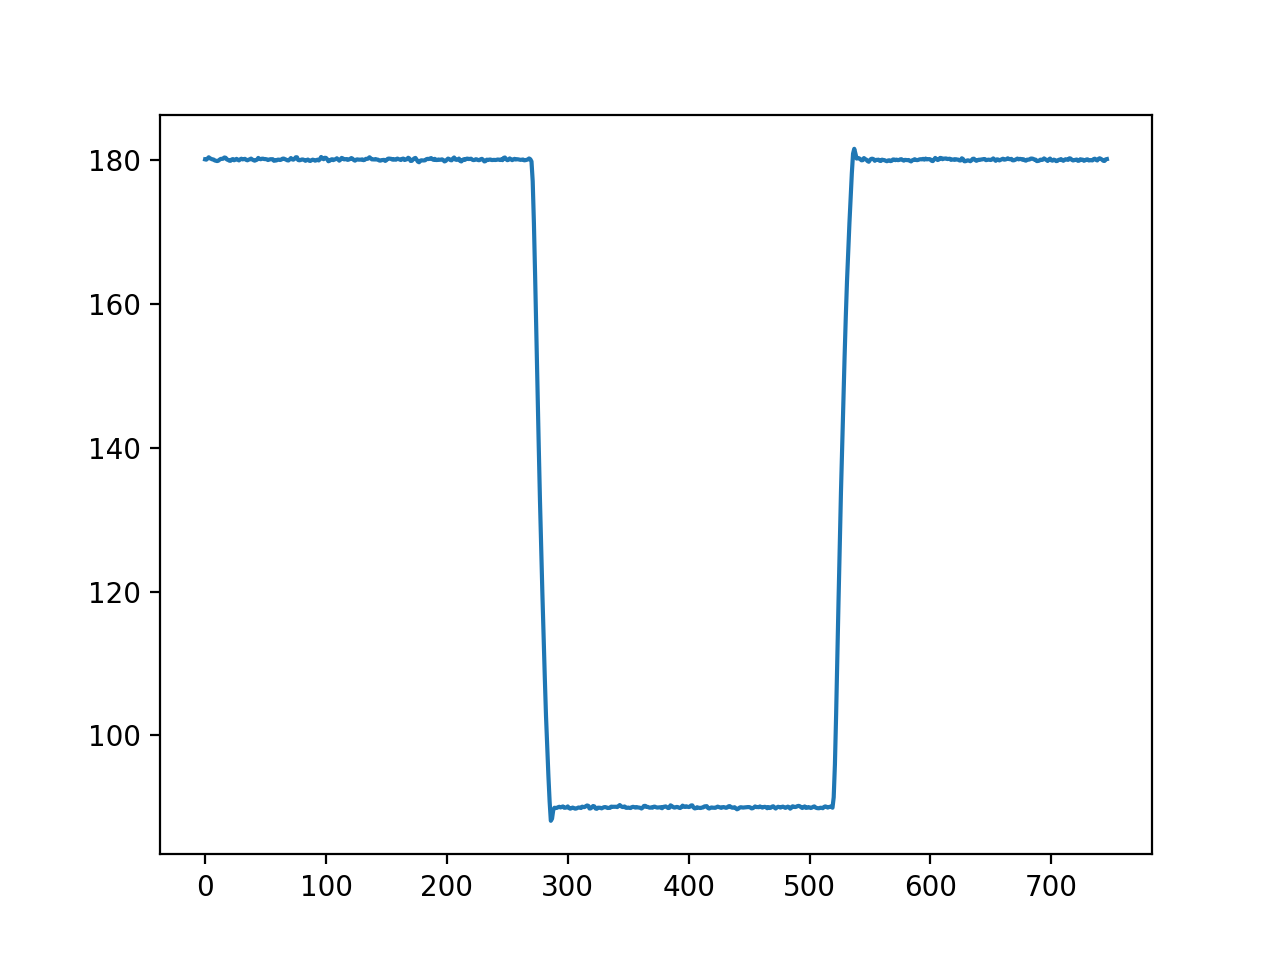

In [101]:
plt.figure()
plt.plot(position)
plt.show()

<IPython.core.display.Javascript object>


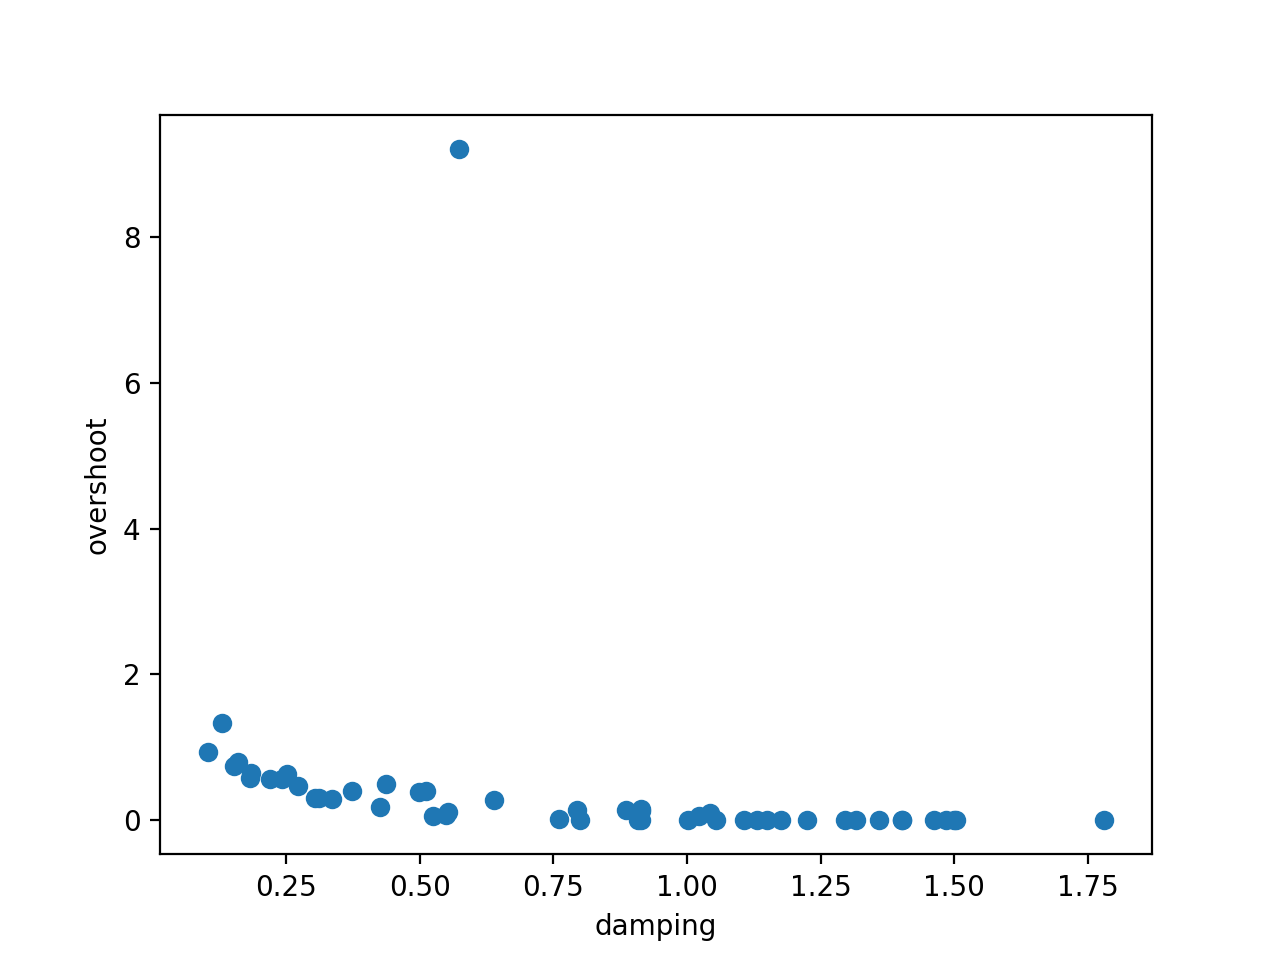

In [102]:
param_matrix = load_all_data("time_angle_*.npy")
plt.figure()
plt.scatter(param_matrix[:,6],param_matrix[:,3])
plt.xlabel('damping')
plt.ylabel('overshoot')
plt.show()

Max overshoot Mp: 0.0158501440922
Rise time tr: 0.022s
Settling time: 0.074s

Estimated damping from Mp: 0.796929059442
Estimated natural freq wn: 81.8181818182
Estimated ts: 0.0706278842733
Estimated damping from trts: 0.760613694382


<IPython.core.display.Javascript object>


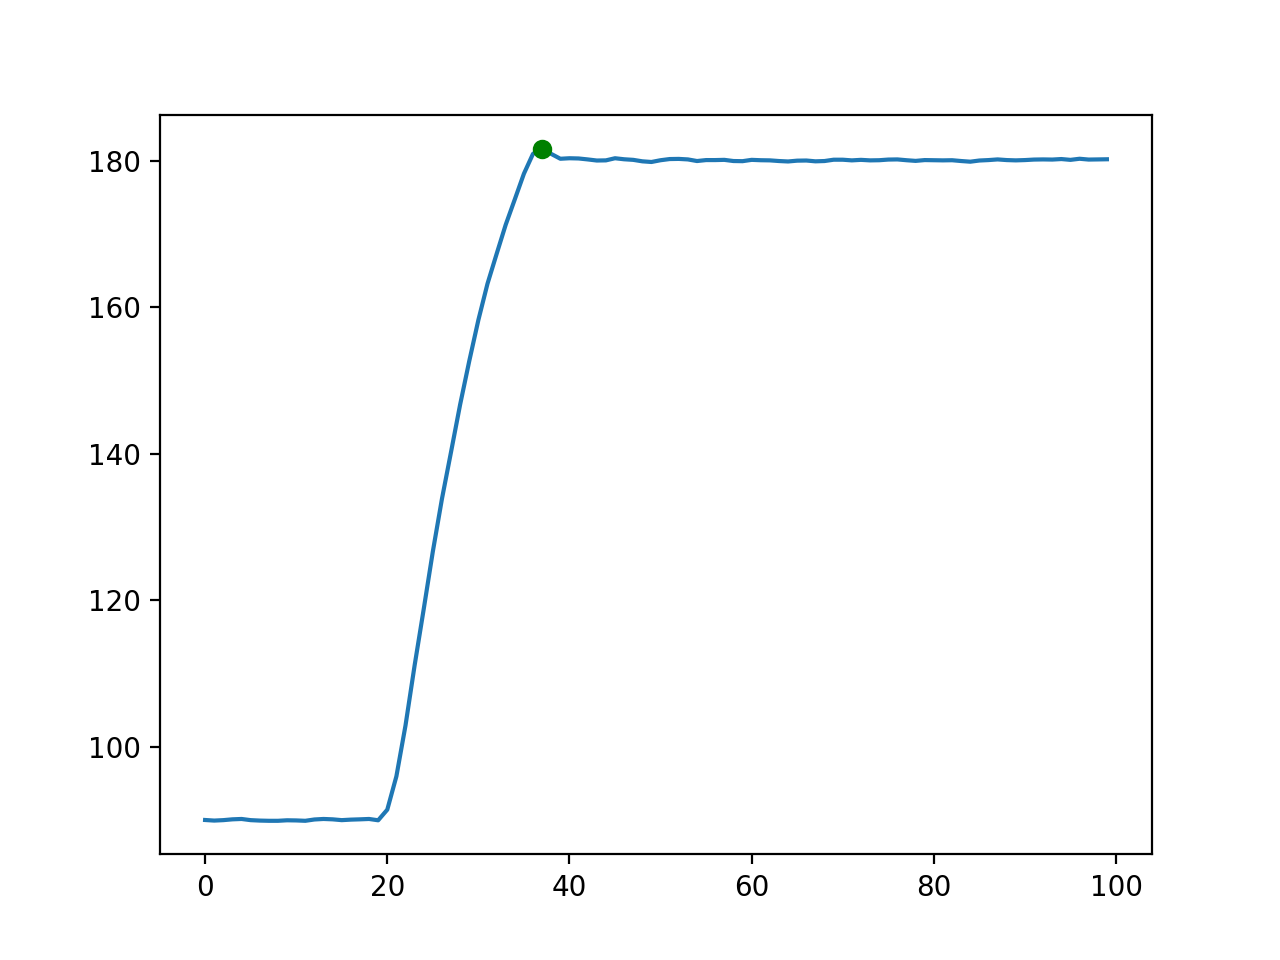

In [103]:
dt = 0.002

Mp = overshoot(step2_data)
print('Max overshoot Mp: ' + str(Mp))

tr = rise_time(step2_data, dt)
print('Rise time tr: ' + str(tr) + 's')

ts = settling_time(step2_data, dt)
print('Settling time: ' + str(ts) + 's')

damp = damping_from_Mp(step2_data)
print('\nEstimated damping from Mp: ' + str(damp))

wn = 1.8/tr
print('Estimated natural freq wn: ' + str(wn))

ts_est = -np.log(0.01) / (damp*wn)
print('Estimated ts: ' + str(ts_est))

damp_est = damping_from_tstr(step2_data,dt)
print('Estimated damping from trts: ' + str(damp_est))


# Plot the second step and highlight offending point
plt.figure()
datacursor()
plt.plot(np.arange(step2_data.size),step2_data)
# highlight the first point in bounds
plt.plot(ts/dt, step2_data[int(ts/dt)], 'go')

In [104]:
def plot_pid_response(encoder,set_point,kp,kd,dt,index_range,plot_output=True):
    position_sub = encoder[slice(*index_range)]
    vel_sub = np.diff(encoder)[slice(*index_range)] / dt
    
    p_term = (position_sub - set_point)*kp
    d_term = vel_sub*kd
    output = np.clip(p_term + d_term,-1,1)
    
    plt.figure()
    plt.plot(p_term,label='p_term')
    plt.plot(d_term,label='d_term')
    if plot_output:
        plt.plot(output,label='output')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


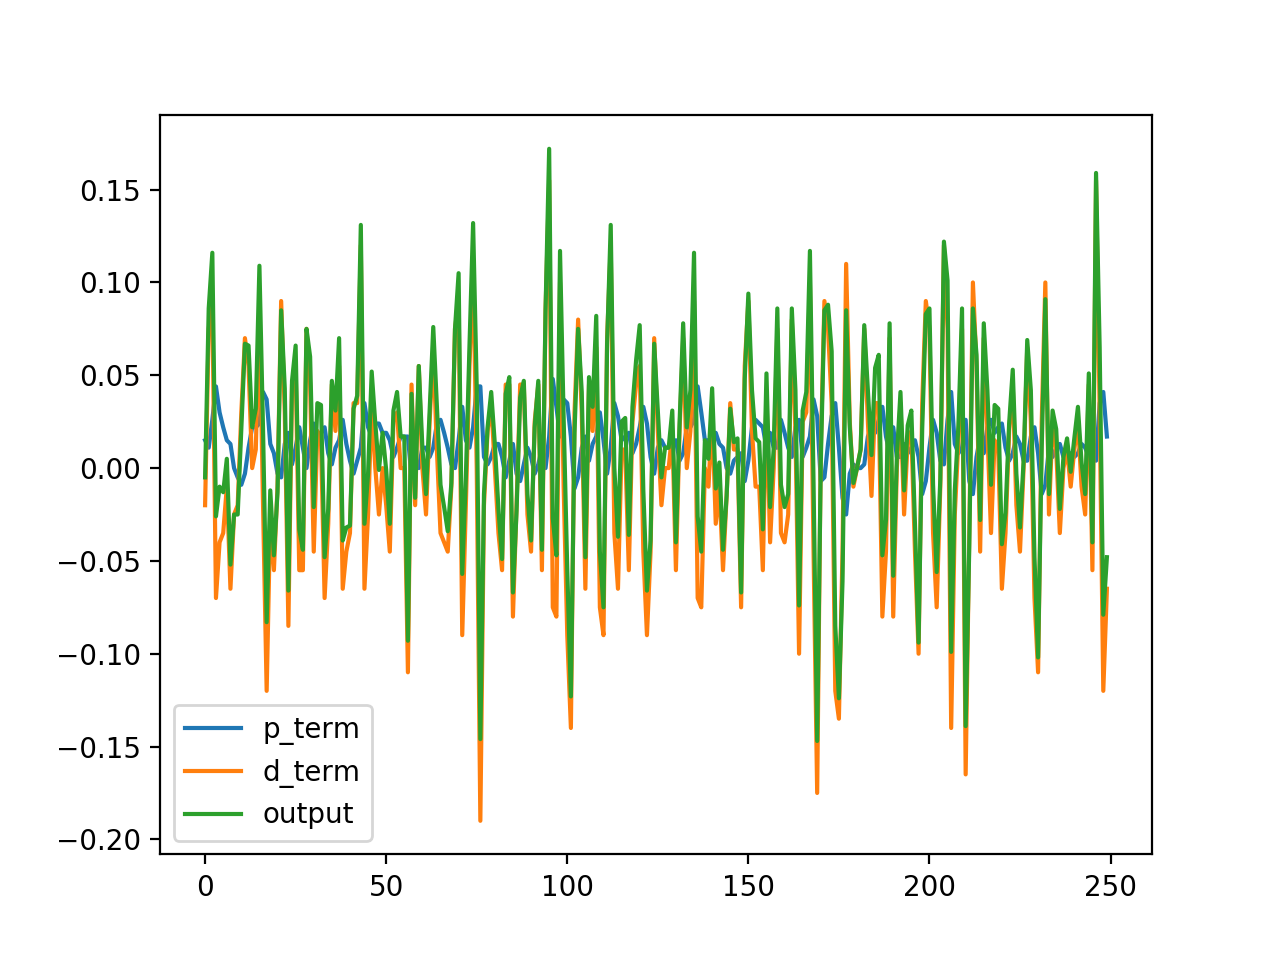

In [105]:
plot_pid_response(position,180.0,0.1,0.001,0.002,phase1_index,plot_output=True)

<IPython.core.display.Javascript object>


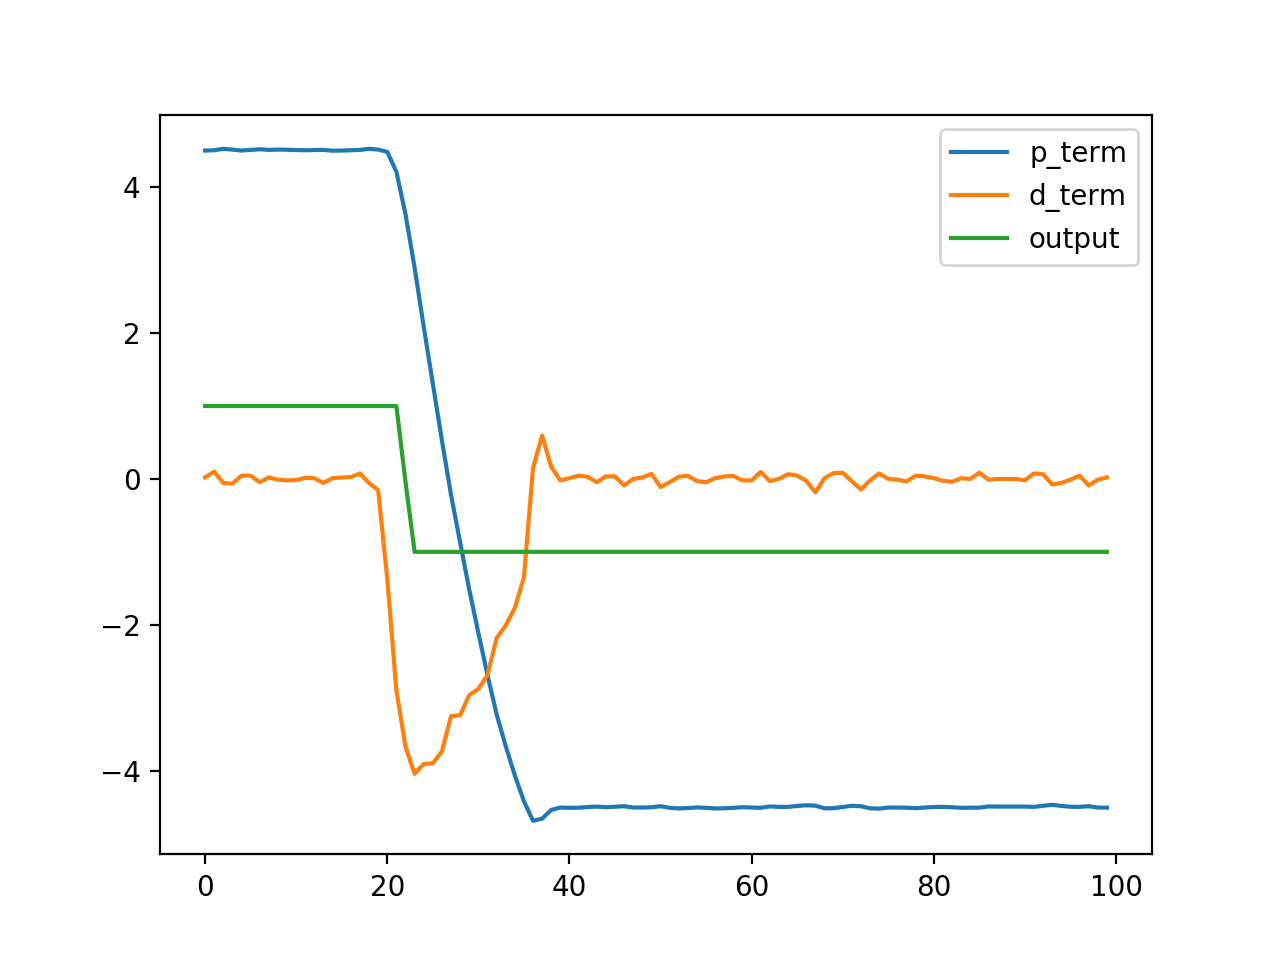

In [106]:
plot_pid_response(position,135.0,0.1,0.001,0.002,step1_index)

<IPython.core.display.Javascript object>


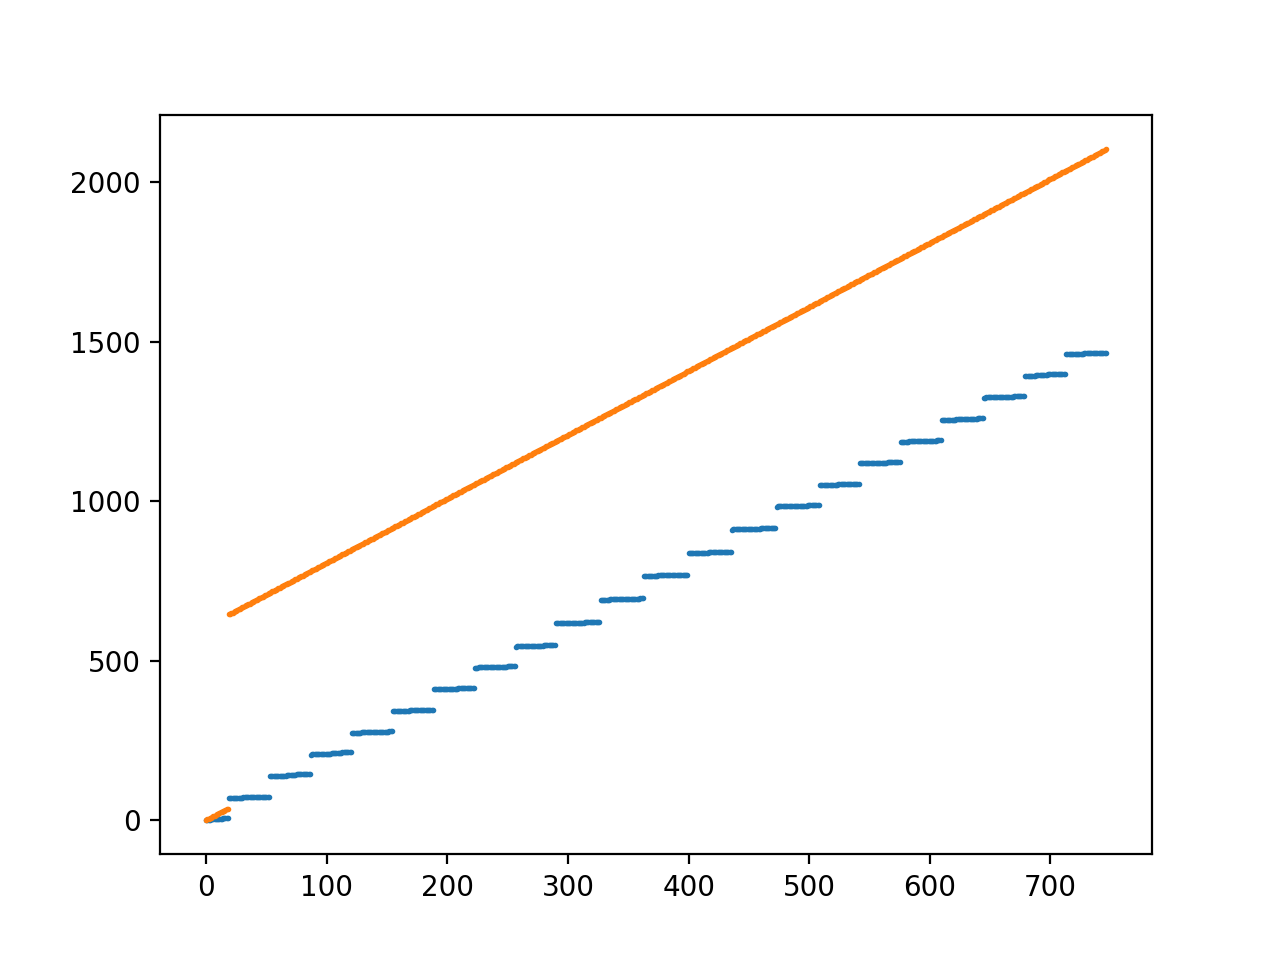

In [107]:
# Look at weird time stamps from received messages

plt.figure()
plt.scatter(np.arange(np.shape(comp_timestamps)[0]),comp_timestamps,s=1)
plt.scatter(np.arange(np.shape(times)[0]),times,s=1)
# datacursor()
plt.show()

<IPython.core.display.Javascript object>


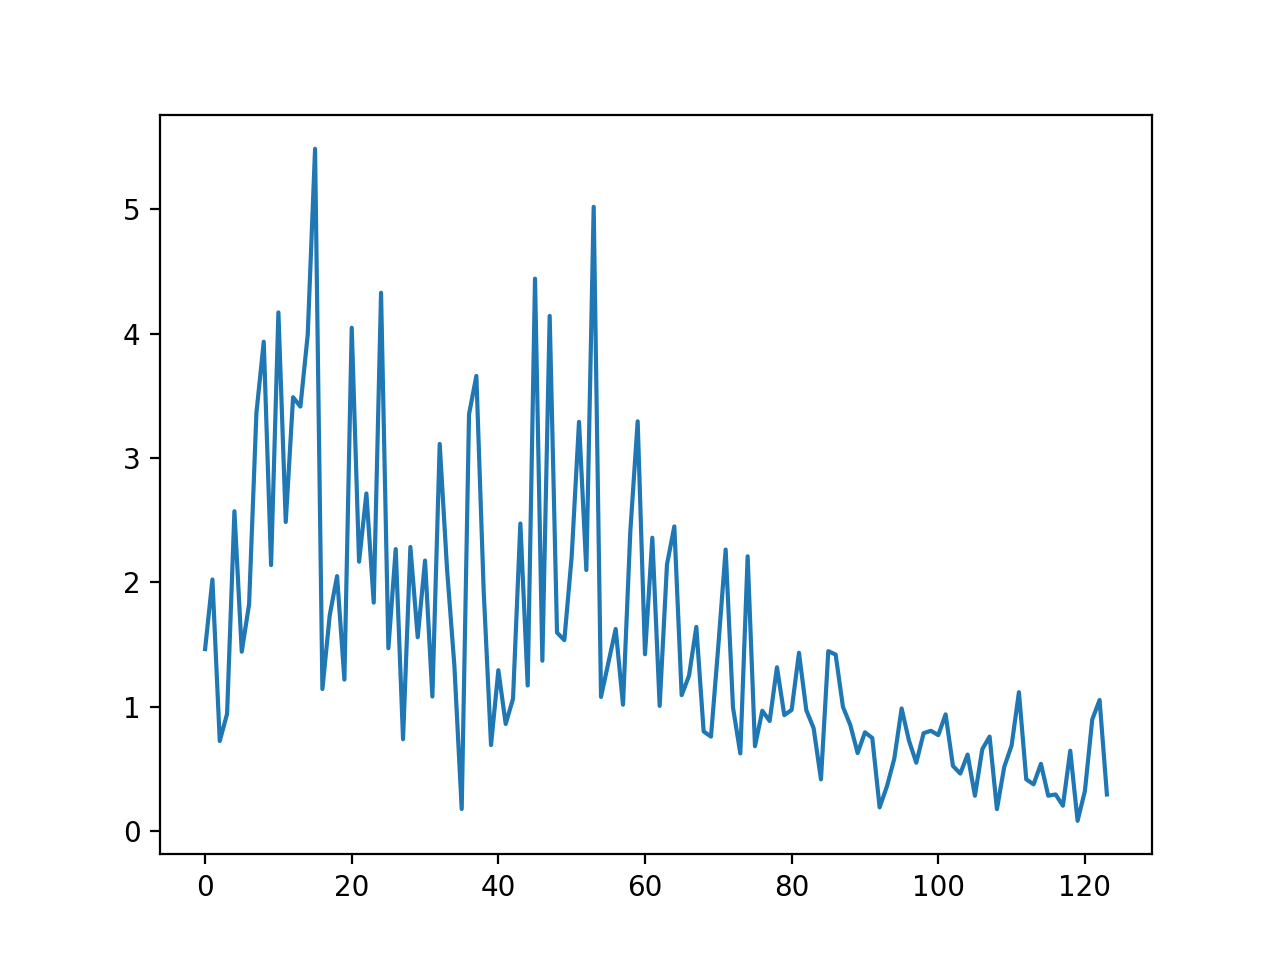

In [108]:
### Analyze vibrations at a set point ###

from scipy.fftpack import fft
pos_slice = phase1_data
# plt.figure()
# plt.plot(pos_slice)
fft_pos = np.abs(fft(pos_slice))
fft_pos = fft_pos[1:int(fft_pos.size/2)]

plt.figure()
plt.plot(np.arange(fft_pos.size),fft_pos)

In [109]:
def theoretical_specs(m,b,k):
    print('m: {} b: {} k: {}'.format(m,b,k))

    w_natural = np.sqrt(k/m)
    damping_k = b/(2*np.sqrt(k*m))
    print('w_natural: {}'.format(w_natural))
    print('damping: {}'.format(damping_k))

    tr = 1.8/w_natural
    print('Tr: {}'.format(tr))

    ts = -np.log(0.01)/(w_natural*damping_k)
    print('Ts: {}'.format(ts))

    Mp = np.exp(-damping_k*np.pi/(np.sqrt(1-damping_k**2)))
    print('Mp: {}'.format(Mp))


Iz = 2.1e-5; Kt = 0.028; I_max = 15
m = Iz/(Kt*I_max); b = 0.001; k = 0.1

theoretical_specs(m,b,k)

m: 5e-05 b: 0.001 k: 0.1
w_natural: 44.721359549995796
damping: 0.22360679774997896
Tr: 0.04024922359499621
Ts: 0.4605170185988091
Mp: 0.4863966750707109


In [110]:
tr_actual = 0.01
k = 0.1
b = 0.001
new_m = (tr_actual/1.8)**2*k
print('new m from rise time: {}'.format(new_m))

Mp = 0.25
d_Mp = damping_from_Mp_given_Mp(Mp)
print('damping: {}'.format(d_Mp))

new_m = b**2/(4*k*d_Mp**2)
print('new mass from damping: {}'.format(new_m))

new m from rise time: 3.08641975308642e-06
damping: 0.40371275194342066
new mass from damping: 1.533893028451489e-05
